# Model evaluation

##### Libraries

In [37]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Goals of this lecture
 
- Why is evaluating models important? (Today's focus: **classifiers**.)
- **Metrics**:
   - Accuracy.  
   - [Type 1 vs. Type 2 errors](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors).
   - [Precision vs. Recall](https://en.wikipedia.org/wiki/Precision_and_recall).
   - [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
- **Visualization techniques**:
   - [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
   - [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

## Why evaluate models?

### Science is about building models

> A central goal of science is building **models** of the world. This includes verbal explanations but also and especially **statistical models**. 

Typically, we want our models to be:

- **Accurate**: they should be a good description of the data.
- **Parsimonious**: they shouldn't be more complicated than they need to be.

### Many *possible* models

> Given any dataset $d$, there are many *possible* models $m_1, m_2, ..., m_n$ we could build of that dataset.

Which model is "best"?

- Here, "best" is always relative to some goal. 
   - Best at predicting $Y$?  
   - Most theoeretically interesting?
- This process of selecting the best model is called **model selection**.

### *Comparing* models

> In order to select the best model, researchers often **compare** multiple models in terms of their predictive power.

These model comparison approaches typically incorporate:

1. A measure of **accuracy**: how well do $m_1$ vs. $m_2$ fit the data, $d$?
2. A measure of **complexity**: how complex are $m_1$ and $m_2$, respectively?

### Review: evaluating linear models

We've already discussed several approaches to evaluating and comparing **linear regression models**:

- $R^2$: what proportion of variance in $Y$ is explained by $X$?  
- $Adj. R^2$: what proportion of variance in $Y$ is explained by $X$, adjusting for $n$ and $p$?
- $MSE$: how much *squared error* does our model of $Y$ typically have? 

In combination with **cross-validation**, these techniques allow us to compare the **accuracy** of models while also penalizing **over-fitting**.

### Bias-variance trade-off revisited

- Red line = test error.
- Blue line = train error.

![title](img/bias.png)

[Screenshot from *The Elements of Statistical Learning*](https://hastie.su.domains/ElemStatLearn/).

## Evaluating classifiers: metrics

Today, we'll be focusing on evaluating **classification models**.

- Some of these metrics also apply to linear models, like AIC.  
- But others (like [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)) are limited to *categorical* data.

### Loading the dataset

In [39]:
df_spam = pd.read_csv("data/models/classification/email.csv")
df_spam.head(2)

,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,winner,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
0,0,0,1,0,0,2012-01-01T06:16:41Z,0,0,0,no,...,0,0,11.370,202,1,0,0,0,0,big
1,0,0,1,0,0,2012-01-01T07:03:59Z,0,0,0,no,...,0,0,10.504,202,1,0,0,0,1,small


### Accuracy

> The **accuracy** of a model is the number of **correct predictions** divided by the total number of observations.

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

Where:

- $TP$: True positive.
- $TN$: True negative.
- $FP$: False positive.
- $FN$: False negative.

#### Assessing accuracy

A straightforward way to assess accuracy is to simply compare the **true labels**, $Y$, to the **predicted labels**, $\hat{Y}$.

In [40]:
true_labels = np.array([1, 0, 0, 1, 0, 0])
predicted_labels = np.array([1, 0, 1, 1, 0, 1])
correct_response = true_labels == predicted_labels
correct_response

array([ True,  True, False,  True,  True, False])

In [41]:
### Accuracy
correct_response.mean()

0.6666666666666666

#### Using `accuracy_score`

The `accuracy_score` function in `sklearn` will do this for you.

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
accuracy_score(true_labels, predicted_labels)

0.6666666666666666

#### But where do the predictions come from?

Many models, such as logistic regression, produce a **probability** of the outcome, i.e., $p(spam)$. 

How would you convert $p(spam)$ to an actual **prediction**, i.e., `spam` vs. `not spam`?

- This requires **thresholding** your probability score at a certain value of $p$.  
   - If $p_i > t$: `spam`.  
   - If $p_i ≤ t$: `not spam`.

#### Naive approach: threshold at $p = .5$

A naive approach is to create a **threshold** at $p = .5$.

In [44]:
predicted_probability = np.array([.6, .2, .7, .7, .4, .55])
predicted_labels = (predicted_probability > .5).astype(int)
predicted_labels

array([1, 0, 1, 1, 0, 1])

In [45]:
accuracy_score(predicted_labels, true_labels)

0.6666666666666666

#### Check-in

Can anyone think of any potential issues with this naive threshold of $p_t = .5$?

#### The importance of thresholding

Depending on the **base rate** of $Y$ in your dataset, $p_t = .5$ might generate either:

- Too many false positives.  
- Too many false negatives.

#### Thresholding in practice (pt. 1)

What do we notice about the **distribution** of predicted probabilities from our model predicting `spam`?

Optimization terminated successfully.
         Current function value: 0.271057
         Iterations 9


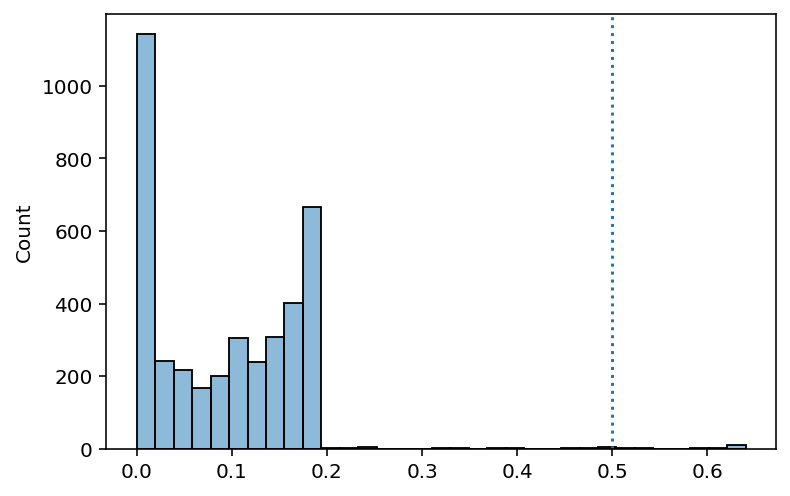

In [46]:
## Fit a model
mod_spam = smf.logit(data = df_spam, formula = "spam ~ winner + num_char + re_subj").fit()
## Get predictions
y_pred = mod_spam.predict()
## Visualize predicted probabilities
sns.histplot(x = y_pred, alpha = .5)
plt.axvline(x = .5, linestyle = "dotted")

#### Thresholding in practice (pt. 2)

- If we use $p_t = .5$, then we classify very few instances as `spam`.
- Though because `spam` is relatively rare, we actuall have decently high accuracy...

In [47]:
labels_t5 = y_pred > .5
print("Proportion classified as spam: {x}".format(x = round(labels_t5.mean(), 4)))
print("Proportion actual spam: {x}".format(x = round(df_spam['spam'].mean(), 4)))
print("Accuracy: {x}".format(x = round(accuracy_score(labels_t5, df_spam['spam']), 2)))

Proportion classified as spam: 0.0048
Proportion actual spam: 0.0936
Accuracy: 0.91


#### Thresholding in practice (pt. 3)

- We can also test out different **thresholds** to see how accuracy scales with $p_t$.
- **Note**: keep in mind that it also matters **how** the model is going wrong...

In [48]:
results = []
for t in np.arange(0, 1, .01):
    labels = y_pred > t
    accuracy = accuracy_score(labels, df_spam['spam'])
    results.append({'accuracy': accuracy, 't': t, 'pred_spam': labels.mean()})

<AxesSubplot:xlabel='t', ylabel='accuracy'>

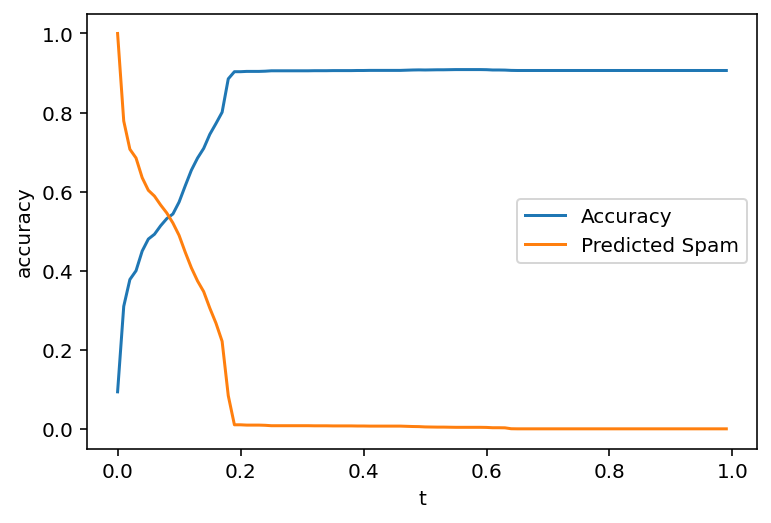

In [49]:
df_results = pd.DataFrame(results)
sns.lineplot(data = df_results, x = "t", y = "accuracy", label = "Accuracy")
sns.lineplot(data = df_results, x = "t", y = "pred_spam", label = "Predicted Spam")

#### Check-in

Relating to thresholding: are there any issues with just naively using accuracy?

#### The problem of "naive accuracy"

Depending on the **base rate** of $Y$, *very high accuracy* could be achieved by simply always guessing the same thing.

- If fraud is very rare ($p(Y) = .01$), then always guessing `not fraud` will yield $99\%$ accuracy.  
- However, it also means you'd **miss** every real instance of `fraud`.

This raises the issue of [Type 1 vs. Type 2 errors](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors).

### Type 1 vs. Type 2 Errors

Models can be [wrong in *different ways*](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors).

- A **Type 1 Error** is *incorrectly rejecting the null hypothesis*, i.e., a **false positive**.  
- A **Type 2 Error** is *incorrectly failing to reject the null hypothesis*, i.e., a **false negative**.

| |predicted label = `not spam`|predicted label = `spam`|
|--|-----------------------|-------------------
|true label = `not spam`| Correct (True Negative) | False Positive |
|true label = `spam` | False Negative | Correct (True Positive) |

#### Review: Different errors have different *costs*

![title](img/bias_northpointe.png)

[Source: Propublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)


#### Calculating the *false positive rate*

> The **false positive rate** is the proportion of *negative classes* (e.g., `not spam`) incorrectly categorized as a *positive class* (e.g., `spam`).

$FPR = \frac{FP}{N}$

Where:

- $FP$: The number of false positives.  
- $N$: The number of *negative* classes.

##### Demo: FPR

In [50]:
## Demo: true data
true_labels = np.array([1, 0, 0, 1, 0, 0])
## Demo: predicted labels
predicted_labels = np.array([1, 0, 1, 1, 0, 1])

In [51]:
## Number of true negatives
N = len(true_labels[true_labels==0])
## Number of FP
FP = len(predicted_labels[(predicted_labels==1) & (true_labels == 0)])

In [52]:
## FP Rate
FP / N

0.5

#### Calculating the *false negative rate*

> The **false negative rate** is the proportion of *positive classes* (e.g., `spam`) incorrectly categorized as a *negative class* (e.g., `not spam`).

$FNR = \frac{FN}{P}$

Where:

- $FN$: The number of false negatives.  
- $P$: The number of *positive* classes.

##### Demo: FNR

In [53]:
## Demo: true data
true_labels = np.array([1, 0, 0, 1, 0, 0])
## Demo: predicted labels
predicted_labels = np.array([1, 0, 1, 1, 0, 1])

In [54]:
## Number of true negatives
P = len(true_labels[true_labels==1])
## Number of FP
FN = len(predicted_labels[(predicted_labels==0) & (true_labels == 1)])

In [55]:
## FP Rate
FN / P

0.0

#### Coming up: confusion matrices

Soon, we'll discuss how to build a **confusion matrix**, which contains information about the false positive and false negative rates, as below:

| |predicted label = `not spam`|predicted label = `spam`|
|--|-----------------------|-------------------
|true label = `not spam`| Correct (True Negative) | False Positive |
|true label = `spam` | False Negative | Correct (True Positive) |

### Precision vs. Recall

> [**Precision** and **Recall**](https://en.wikipedia.org/wiki/Precision_and_recall) are finer-grained measures of a model's performance that account for false positives and false negatives. 

- **Precision**: what proportion of items classified as `spam` are actually `spam`?
- **Recall**: what proportion of actual `spam` was successfully recognized as `spam`? 




![title](img/recall.png)

[Image source: Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

#### Calculating precision

$Precision = \frac{TP}{P*} = 1 - FPR$

Where:

- $TP$: How many true positives?  
- $P*$: How many predicted positives?

In [56]:
from sklearn.metrics import precision_score

In [57]:
true_labels = np.array([1, 0, 0, 1, 0, 0])
predicted_labels = np.array([1, 0, 1, 1, 0, 1])
precision_score(true_labels, predicted_labels)

0.5

#### Calculating recall

$Recall = \frac{TP}{P} = 1 - FNR$

Where:

- $TP$: How many true positives?  
- $P*$: How many actual positives?

In [58]:
from sklearn.metrics import recall_score

In [59]:
true_labels = np.array([1, 0, 0, 1, 0, 0])
predicted_labels = np.array([1, 0, 1, 1, 0, 1])
recall_score(true_labels, predicted_labels)

1.0

### Akaike Information Criterion (AIC)

> **Akaike Information Criterion (AIC)** is a measure of *model fit* that factors in both the **accuracy** of the model and the **complexity** of the model.

$AIC = 2k - 2*log(\mathcal{L})$

Where:

- $k$: number of parameters (predictors) in the model.  
- $\mathcal{L}$: the **likelihood** of the model.

#### What is "likelihood"?

> The **likelihood** of a model is a measure of the *probability* of the data, given the model.

- Recall that a model $M$ is a model of the **data-generating process**.  
- Likelihood is a way of asking:
   - If $M$ generated predictions $\hat{Y}$ from input $X$...
   - ...How *similar* are these predictions to the actual data, $Y$}?
   
What does this remind you of?

#### Likelihood vs. $RSS$

The **residual sum of squares** ($RSS$) measures:

$RSS = \sum_i^N{(y_i - \hat{y}_i)^2}$

**Likelihood** is technically a *generalization* of this approach:

$\mathcal{L(X | \theta)} = \prod_i^Np(y_i | \theta)$

Where:

- $\theta$: the parameters $\beta_0, \beta_1, ..., \beta_n$.  
- $p(y_i | \theta)$: the probability of an actual observation, $y_i$, given the model parameters $\theta$.

#### Extracting and interpreting AIC

- The actual $AIC$ number won't mean much, as it depends on the variance in the data, $N$, and more (similar to $MSE$).
- $AIC$ is primarily useful for comparing different models. 
- A **lower** $AIC$ is better.

In [60]:
m1 = smf.logit(data = df_spam, formula = "spam ~ num_char").fit()
m2 = smf.logit(data = df_spam, formula = "spam ~ winner").fit()

Optimization terminated successfully.
         Current function value: 0.299210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.307661
         Iterations 6


In [61]:
print(m1.aic)
print(m2.aic)

2350.4011465188078
2416.6742247296415


#### $AIC$ in practice

Typically, $AIC$ is **rescaled** by subtracting the $AIC$ of the best model (i.e., the lowest $AIC$ value) from each of the $AIC$ values in question.

- Thus, the *best* model has a rescaled $AIC$ of `0`.
- The rescaled $AIC$ value reflects the **difference** from the best model.

In [62]:
rescaled = np.array([m1.aic, m2.aic]) - m1.aic
rescaled

array([ 0.        , 66.27307821])

## Evaluating models with *visualizations*

Beyond **metrics**, we can evaluate models by making visualizations about their predictive success. We'll focus on:

- Confusion matrix.  
- ROC Curve.

### Confusion matrix

> A **confusion matrix** compares a model's predictions to actual values of $Y$, allowing a viewer to determine which classes were most frequently "confused" (i.e., where the **error rate** was highest).


| |predicted label = `not spam`|predicted label = `spam`|
|--|-----------------------|-------------------
|true label = `not spam`| Correct (True Negative) | False Positive |
|true label = `spam` | False Negative | Correct (True Positive) |

#### Confusion matrix in practice

`sklearn` has a `confusion_matrix` function, which takes as input the true labels (`y_true`) and the predicted labels (`y_pred`).

To interpret the output:

- The **rows** refer to the *real labels* of $Y$.  
- The **columns** refer to the *predicted labels*, $\hat{Y}$.
- The **diagonal** of the matrix are the correct responses.
   - Ideally, all other cells should be *zero*: no errors.
- Each **cell** thus refers to the intersection:
   - How many times did we predict `0` when it was actually a `1`?
   - How many times did we predict `1` when it was actually a `0`?

#### Check-in

Based on this confusion matrix, what is the number of:

- True positives?  
- False positives? 
- True negatives?  
- False negatives?

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2, 2],
       [0, 2]])

#### Normalizing our output

We can also **normalize** the output using the `normalize = 'true'` parameter.

Based on this confusion matrix, what is our **false positive rate**? What about our **false negative rate**?

In [65]:
cm = confusion_matrix(true_labels, predicted_labels, normalize = 'true')
cm

array([[0.5, 0.5],
       [0. , 1. ]])

#### Visualizing with `seaborn`

We can use `seaborn.heatmap` to visualize the output of a confusion matrix.

<AxesSubplot:>

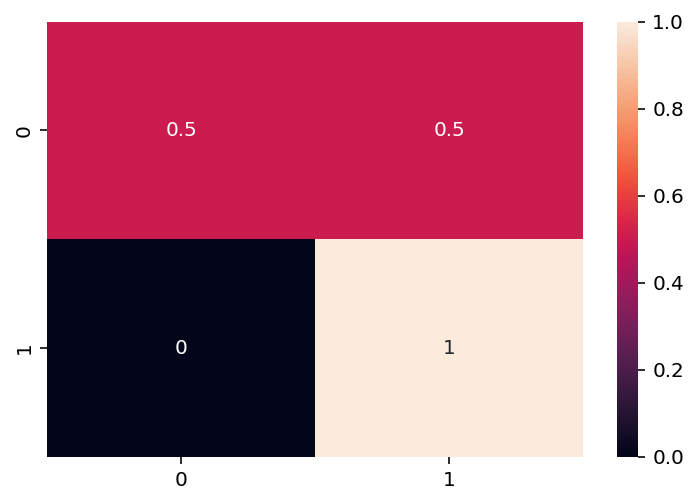

In [66]:
sns.heatmap(cm, annot = True)

### ROC Curve

> A **Receiver Operating Characteristic (ROC) Curve** illustrates the ability of a binary classifier to discriminate between classes as its **threshold** ($p_t$) is adjusted.

- x-axis: false positive rate for a given threshold.  
- y-axis: true positive rate for a given threshold.

![title](img/roc.png)


#### Check-in

If $p_t = 0$ (i.e., everything with $p_i ≥ 0$ is labeled `spam`), what should our **false positive rate** and **true positive rate** be?

#### Solution

When $p_t = 0$ (i.e., everything with $p_i ≥ 0$ is labeled `spam`):

- Our true positive rate will be $100\%$: we never miss an instance of `spam`. 
- Our false positive rate will also be $100\%$: we classify every instance of `not spam` as `spam`.

#### ROC Curve in practice

Steps involved in building an ROC Curve:

1. Fit a classifier to your data, and extract predicted probabilities $p_i$.  
2. Consider a **range** of thresholds of $p_t$, from $[0, 1]$. 
3. For each threshold, calculate the **false positive rate (FPR)** and **true positive rate (TPR)**.  
4. Plot `TPR ~ FPR` and compare to random performance.  
5. (Optional) Calculate the **area under the curve** (AUC) between the classifier performance and random chance.

#### Step 1: Fit a model

In [68]:
model = smf.logit(data = df_spam, formula = "spam ~ winner + num_char + re_subj").fit()
y_pred = model.predict()

Optimization terminated successfully.
         Current function value: 0.271057
         Iterations 9


Text(0.5, 0, 'Predicted p(spam)')

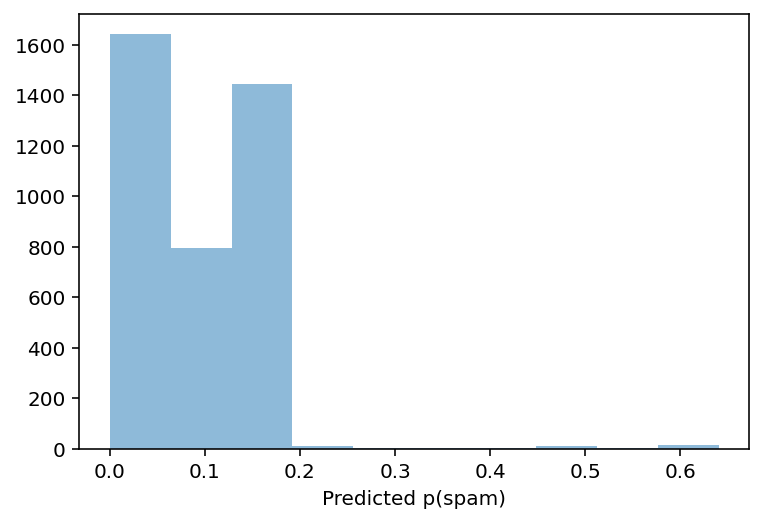

In [71]:
p = plt.hist(y_pred,alpha = .5)
plt.xlabel("Predicted p(spam)")

#### Step 2: Consider a range of thresholds

In [73]:
thresholds = np.arange(0, 1, .01)
true_labels = df_spam['spam']

#### Step 3: Calculate FPR and TPR

In [90]:
results = []
for t in thresholds:
    predicted_labels = y_pred > t
    
    ## Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, normalize = 'true')
    
    ## Extract FPR and TPR
    fpr = cm[0, 1]
    tpr = cm[1, 1]
    
    results.append({'tpr': tpr, 'fpr': fpr})

#### Step 4: Visualize

<AxesSubplot:xlabel='fpr', ylabel='tpr'>

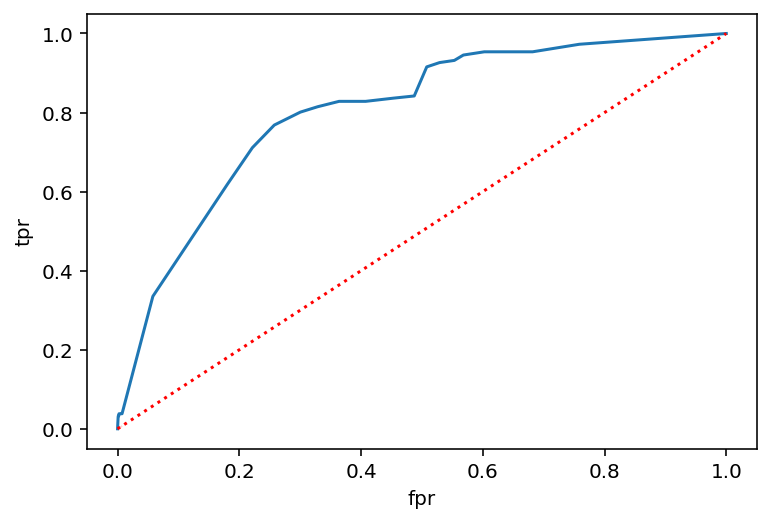

In [91]:
df_results = pd.DataFrame(results)
sns.lineplot(data = df_results, x = "fpr", y = "tpr")
sns.lineplot(data = df_results, x = "fpr", y = "fpr", linestyle = "dotted", color = "red")

#### Why ROC curve is useful

In principle, we can plot the ROC curve for **multiple models**.  

- This gives us a clear way to visualize the relative rate of **false positives** and **true positives** for different models.  
- Depending on whether we're worried more about FPR or TPR, this may help us decide which model is best.

#### `roc_curve` in `sklearn`

We can also use the `roc_curve` function in `sklearn` to build an **ROC Curve** much more easily!

```python
roc_curve(y_true, y_score)
```

This returns the `fpr`, `tpr`, and `thresholds` used.

In [92]:
from sklearn.metrics import roc_curve

<AxesSubplot:>

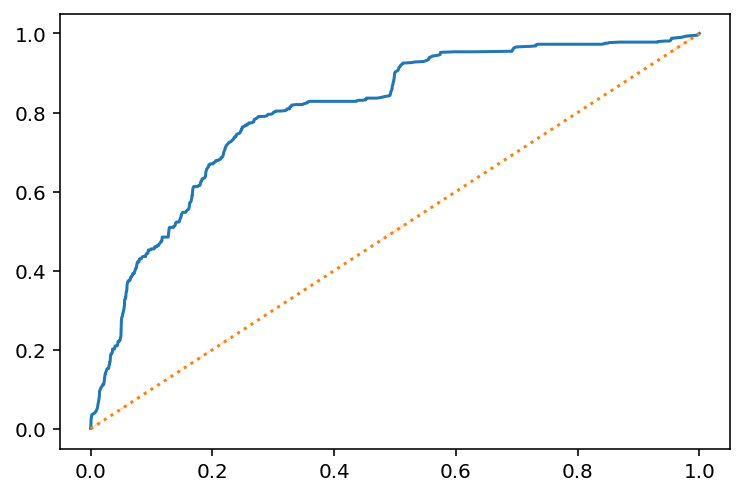

In [95]:
fpr, tpr, thresholds = roc_curve(true_labels, y_pred)
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = fpr, y = fpr, linestyle = "dotted")

## Conclusion

- Once we've built a statistical model, we need to **evaluate** it.  
- There are many approaches to evaluating models, but we've discussed a few:
   - Using **metrics** like accuracy, precision/recall, and $AIC$.
   - Using **visualization techniques** like a confusion matrix and ROC Curve.